In [76]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import joblib
import os


MODEL_PATH = "models/lstm"

if not os.path.exists("models"):
    os.makedirs("models")

if not os.path.exists("models/lstm"):
    os.makedirs("models/lstm")

In [77]:
# Data
train_start_date = "01/01/2001"
train_end_date = "06/30/2023"
lookback = 20
window = 5
batch_size = 32

val_start_date = "07/01/2023"
val_end_date = "09/30/2023"

test_start_date = "09/30/2023"
test_end_date = "12/30/2023"


# Training
hidden_dim = 64
output_dim = 1
num_layers = 3

lr = 1e-4
num_epochs = 100
early_stopping_patience = 20

5658

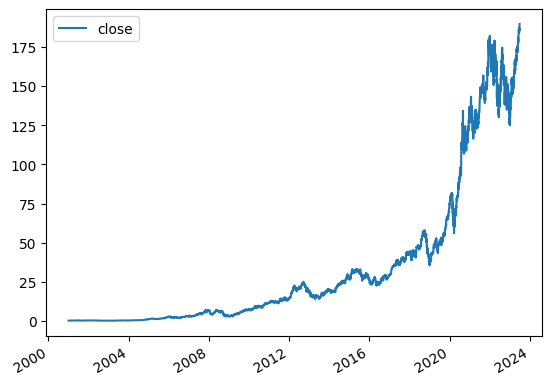

In [78]:
train = si.get_data("aapl", start_date=train_start_date, end_date=train_end_date)[["close"]]
train.plot()
len(train)

In [79]:
train_transformed = train.copy(deep=True)
scaler = MinMaxScaler()
smoothing_window_size = 1000
s = []
scaler.fit(train)
for di in range(0,len(train),smoothing_window_size):
    scaler.fit(train[di:di+smoothing_window_size])
    s.append(scaler)
    train_transformed[di:di+smoothing_window_size] = scaler.transform(train[di:di+smoothing_window_size])


<Axes: >

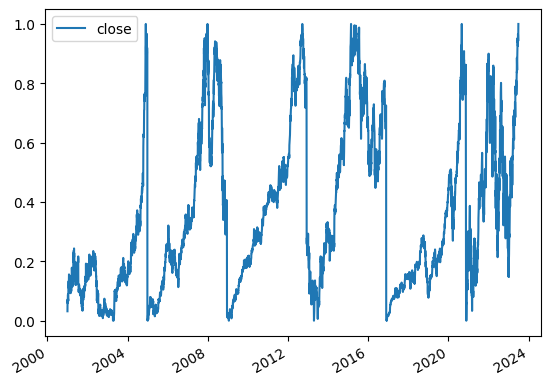

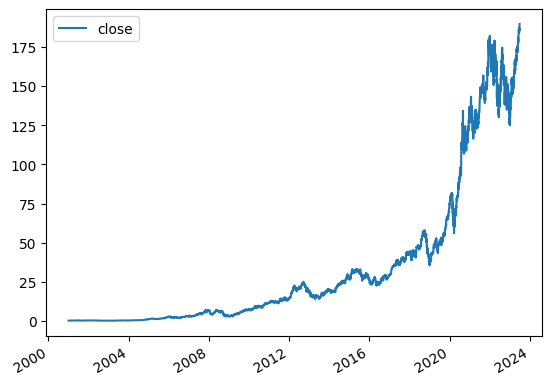

In [80]:
train_transformed.plot()
train.plot()

In [81]:
train_transformed = pd.concat([train_transformed]+[train_transformed.shift(i) for i in range(1,20)], axis=1)
train_transformed.columns = ["close"] + [f"lag_{i}" for i in range(1,20)]
train_transformed = train_transformed.dropna()
train_transformed_aug1 = pd.concat([train_transformed.close.shift(-1)]+[train_transformed.drop("close",axis=1)], axis=1).dropna()
train_transformed_aug2 = pd.concat([train_transformed.close.shift(-2)]+[train_transformed.drop("close",axis=1)], axis=1).dropna()
train_transformed_aug3 = pd.concat([train_transformed.close.shift(-3)]+[train_transformed.drop("close",axis=1)], axis=1).dropna()
train_transformed_aug3
train_transformed_aug = pd.concat([train_transformed]+[train_transformed_aug1]+[train_transformed_aug2]+[train_transformed_aug3], axis=0)
train_transformed_aug


,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
2001-01-30,0.156001,0.154872,0.116458,0.123237,0.133405,0.133405,0.110810,0.115328,0.100641,0.066748,0.072397,0.073527,0.088214,0.062229,0.073527,0.062229,0.058839,0.071267,0.058839,0.031724
2001-01-31,0.153742,0.156001,0.154872,0.116458,0.123237,0.133405,0.133405,0.110810,0.115328,0.100641,0.066748,0.072397,0.073527,0.088214,0.062229,0.073527,0.062229,0.058839,0.071267,0.058839
2001-02-01,0.144703,0.153742,0.156001,0.154872,0.116458,0.123237,0.133405,0.133405,0.110810,0.115328,0.100641,0.066748,0.072397,0.073527,0.088214,0.062229,0.073527,0.062229,0.058839,0.071267
2001-02-02,0.135665,0.144703,0.153742,0.156001,0.154872,0.116458,0.123237,0.133405,0.133405,0.110810,0.115328,0.100641,0.066748,0.072397,0.073527,0.088214,0.062229,0.073527,0.062229,0.058839
2001-02-05,0.127756,0.135665,0.144703,0.153742,0.156001,0.154872,0.116458,0.123237,0.133405,0.133405,0.110810,0.115328,0.100641,0.066748,0.072397,0.073527,0.088214,0.062229,0.073527,0.062229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-20,0.961579,0.938342,0.952733,0.925535,0.917085,0.923422,0.886058,0.880909,0.844600,0.862952,0.867837,0.885926,0.874571,0.837074,0.837734,0.813045,0.780829,0.765646,0.761949,0.796805
2023-06-21,0.942963,0.939530,0.938342,0.952733,0.925535,0.917085,0.923422,0.886058,0.880909,0.844600,0.862952,0.867837,0.885926,0.874571,0.837074,0.837734,0.813045,0.780829,0.765646,0.761949
2023-06-22,0.979799,0.925667,0.939530,0.938342,0.952733,0.925535,0.917085,0.923422,0.886058,0.880909,0.844600,0.862952,0.867837,0.885926,0.874571,0.837074,0.837734,0.813045,0.780829,0.765646
2023-06-23,0.995511,0.965804,0.925667,0.939530,0.938342,0.952733,0.925535,0.917085,0.923422,0.886058,0.880909,0.844600,0.862952,0.867837,0.885926,0.874571,0.837074,0.837734,0.813045,0.780829


,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
2023-07-31,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247,0.821676,0.803229,0.846657
2023-08-01,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247,0.821676,0.803229
2023-08-02,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247,0.821676
2023-08-03,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694,0.778247
2023-08-04,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325,0.698694
2023-08-07,0.323598,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275,0.678325
2023-08-08,0.360108,0.323598,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867,0.743275
2023-08-09,0.298232,0.360108,0.323598,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632,0.772867
2023-08-10,0.289777,0.298232,0.360108,0.323598,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458,0.778632
2023-08-11,0.282859,0.289777,0.298232,0.360108,0.323598,0.444274,0.797079,0.851268,0.967717,1.000000,0.976172,0.875865,0.925058,0.891237,0.857802,0.826672,0.872406,0.948117,0.895465,0.905458


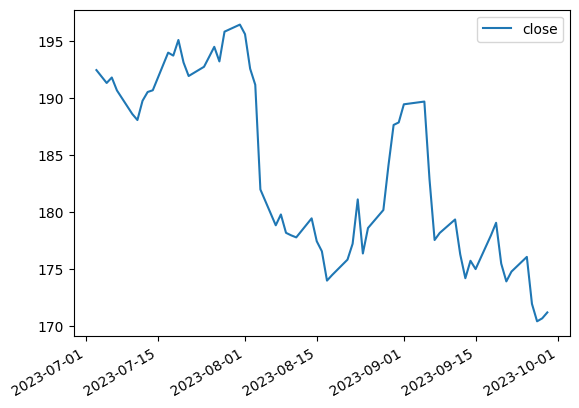

In [82]:
val = si.get_data("aapl", start_date=val_start_date, end_date=val_end_date)[["close"]]
val.plot()
val_transformed = val.copy(deep=True)
val_transformed[:] = scaler.fit_transform(val)
val_transformed = pd.concat([val_transformed]+[val_transformed.shift(i) for i in range(1,20)], axis=1)
val_transformed.columns = ["close"] + [f"lag_{i}" for i in range(1,20)]
val_transformed = val_transformed.dropna()
val_transformed

In [83]:
def get_X_y(train):
    y = train["close"]
    X = train.drop(["close"], axis=1)
    return X, y

train_X, train_y = get_X_y(train_transformed_aug)
val_X, val_y = get_X_y(val_transformed)

In [84]:
train_X = torch.tensor(train_X.values, dtype=torch.float32).unsqueeze(2)
X_val = torch.tensor(val_X.values, dtype=torch.float32).unsqueeze(2)

train_dataset = TensorDataset(train_X, torch.tensor(train_y, dtype=torch.float32).flatten())
val_dataset = TensorDataset(X_val, torch.tensor(val_y, dtype=torch.float32).flatten())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # why shuffle = True? (to avoid overfitting)
val_loader = DataLoader(val_dataset, batch_size=batch_size*4, shuffle=False)

assert train_dataset.tensors[0].shape[1] == lookback-1 # drop lag 0 

/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_59381/4025167369.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_dataset = TensorDataset(train_X, torch.tensor(train_y, dtype=torch.float32).flatten())
/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_59381/4025167369.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_dataset = TensorDataset(X_val, torch.tensor(val_y, dtype=torch.float32).flatten())


In [85]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

def validate(test_loader):
    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for X_batch_t, y_batch_t in test_loader:
            y_val_pred = model(X_batch_t).squeeze()
            val_loss = loss_fn(y_val_pred, y_batch_t)
            val_acc = ((y_val_pred > 0.5) == y_batch_t).sum().item() / len(y_batch_t)
            val_losses.append(val_loss.item())
            val_accs.append(val_acc)
    model.train()
    return np.mean(val_losses), np.mean(val_accs)

In [86]:
from tqdm import tqdm
import numpy as np


# Define Model
model = StockLSTM(input_dim=1, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = nn.MSELoss()
# loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5, verbose=True, )

history = np.zeros((num_epochs, len(train_loader)))
val_losses = []
min_val_loss = np.inf
min_val_loss_epoch = -1
best_model = None

# seed everything
torch.manual_seed(7)
np.random.seed(7)


for t in range(num_epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (X_batch, y_batch) in pbar:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if i % 10 == 0 and i != 0:
                pbar.set_description(f"Epoch {t}, MSE: {loss.item():.4f}")
            history[t, i] = loss.item()
            
        val_loss_epoch, val_acc_epoch = validate(val_loader)
        pbar.set_postfix(val_loss=val_loss_epoch, val_acc=val_acc_epoch)
        pbar.refresh()
        val_losses.append(val_loss_epoch)
        # lr_scheduler.step(val_loss_epoch)
        
    # Early stopping
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        min_val_loss_epoch = t
        best_model = model.state_dict()
    
    elif t - min_val_loss_epoch > early_stopping_patience:
        print(f"Stopping early at epoch {t}")
        break

# Load best model
model.load_state_dict(best_model)

Epoch 91, MSE: 0.0011: 100%|██████████| 705/705 [00:11<00:00, 63.38it/s]

Stopping early at epoch 91


<All keys matched successfully>

In [87]:
# Save best model
torch.save(model, f"{MODEL_PATH}/model.pt")
joblib.dump(scaler, f"{MODEL_PATH}/scaler.pkl")

['models/lstm/scaler.pkl']

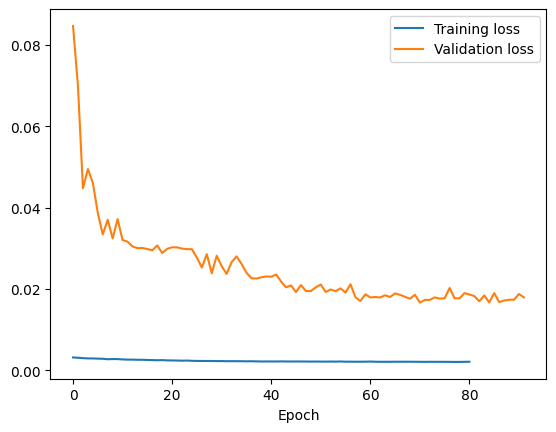

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.mean(axis=1)[10:t], label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")

plt.legend()
plt.show()

In [108]:

y_pred_list = []
test_losses = []
test_accs = []

with torch.no_grad():
    for X_batch_t, y_batch_t in val_loader:
        y_test_pred = model(X_batch_t).squeeze()
        y_pred_list.append(y_test_pred)
        test_loss = loss_fn(y_test_pred, y_batch_t)
        test_acc = ((y_test_pred > 0.5) == y_batch_t).sum() / len(y_batch_t)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())
        
print(y_pred_list)
test_loss = np.mean(test_losses)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {np.mean(test_accs):.4f}")

[tensor([0.9250, 0.9502, 0.9376, 0.9038, 0.8325, 0.2791, 0.1486, 0.1250, 0.1572,
        0.2139, 0.2174, 0.2924, 0.2504, 0.2172, 0.1617, 0.1300, 0.1598, 0.1945,
        0.3230, 0.2674, 0.2852, 0.3319, 0.4329, 0.5956, 0.6944, 0.7565, 0.7672,
        0.6275, 0.3591, 0.2812, 0.2782, 0.2252, 0.1595, 0.1741, 0.1527, 0.2253,
        0.2753, 0.2210, 0.1538, 0.1538, 0.1796, 0.1314, 0.0655, 0.0490])]
Test loss: 0.0179
Test accuracy: 0.0455


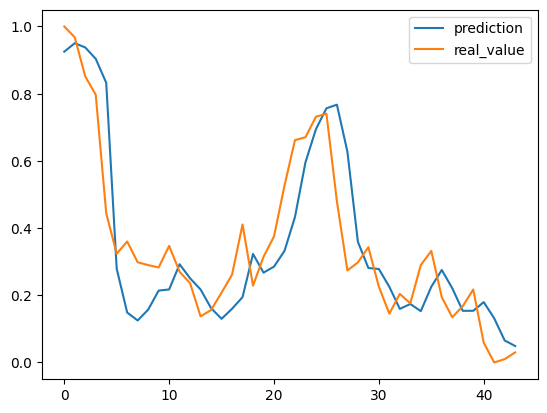

In [109]:
plt.plot(y_pred_list[0].numpy(), label="prediction")
plt.plot(val_transformed[["close"]].to_numpy(), label="real_value")
plt.legend()

,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
2023-07-31,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354,0.387572,0.339526,0.256887,0.216848,0.176489,0.219731
2023-08-01,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354,0.387572,0.339526,0.256887,0.216848,0.176489
2023-08-02,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354,0.387572,0.339526,0.256887,0.216848
2023-08-03,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354,0.387572,0.339526,0.256887
2023-08-04,0.342089,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354,0.387572,0.339526
2023-08-07,0.312620,0.342089,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354,0.387572
2023-08-08,0.395259,0.312620,0.342089,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517,0.368354
2023-08-09,0.478219,0.395259,0.312620,0.342089,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665,0.413517
2023-08-10,0.512492,0.478219,0.395259,0.312620,0.342089,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088,0.442665
2023-08-11,0.497117,0.512492,0.478219,0.395259,0.312620,0.342089,0.226778,0.124279,0.108904,0.042601,0.000000,0.134850,0.209801,0.195708,0.191864,0.274504,0.286675,0.328635,0.378924,0.383088


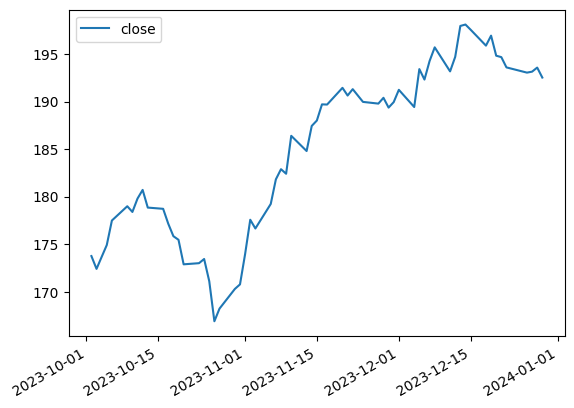

In [100]:
test = si.get_data("aapl", start_date=test_start_date, end_date=test_end_date)[["close"]]
test.plot()
test_transformed = val.copy(deep=True)
test_transformed[:] = scaler.fit_transform(test)
test_transformed = pd.concat([test_transformed]+[test_transformed.shift(i) for i in range(1,20)], axis=1)
test_transformed.columns = ["close"] + [f"lag_{i}" for i in range(1,20)]
test_transformed = test_transformed.dropna()
test_transformed

In [116]:
test_transformed = test_transformed.dropna()

X_test, y_test = get_X_y(test_transformed)
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())
test_loader = DataLoader(test_dataset, batch_size=batch_size*4, shuffle=False)

test_losses = []
test_accs = []
y_pred_list = []
with torch.no_grad():
    for X_batch_t, y_batch_t in test_loader:
        y_test_pred = model(X_batch_t).squeeze()
        y_pred_list.append(y_test_pred)
        test_loss = loss_fn(y_test_pred, y_batch_t)
        test_acc = ((y_test_pred > 0.5) == y_batch_t).sum() / len(y_batch_t)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())
        
print(y_pred_list)
test_loss = np.mean(test_losses)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {np.mean(test_accs):.4f}")


[tensor([0.0705, 0.0688, 0.0750, 0.0913, 0.1572, 0.2496, 0.2876, 0.3466, 0.4197,
        0.4771, 0.5053, 0.5985, 0.5695, 0.6456, 0.6991, 0.7244, 0.7587, 0.7896,
        0.7678, 0.7855, 0.7733, 0.7554, 0.7377, 0.7261, 0.7338, 0.7446, 0.7325,
        0.7988, 0.8055, 0.8449, 0.8787, 0.8635, 0.8831, 0.9376, 0.9339, 0.9496,
        0.9311, 0.9427, 0.9162, 0.8832, 0.8538, 0.8240, 0.8094, 0.8218])]
Test loss: 0.0042
Test accuracy: 0.0227


/var/folders/9k/_vz3shh92wq2gs0dz81qxnjm0000gn/T/ipykernel_59381/876812395.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())


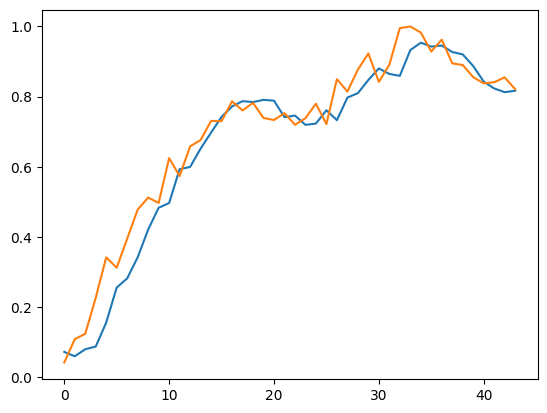

In [112]:
plt.plot(y_pred_list[0].numpy(), label="prediction")
plt.plot(test_transformed[["close"]].to_numpy(), label="actual_value")

In [117]:
steps = 30
x_1_test = X_test.iloc[0,:]
x_1_test = x_1_test.values.tolist()

print(x_1_test)
long_term_pred = []
for step in range(0, steps):
    x = torch.tensor(x_1_test, dtype=torch.float32).unsqueeze(1).unsqueeze(0)
    y_test_pred = model(x).squeeze().detach().item()
    long_term_pred.append(y_test_pred)
    x_1_test.append(y_test_pred)
    x_1_test.pop(0)
    

# with torch.no_grad():
#         y_test_pred = model(X_batch_t).squeeze()
#         y_pred_list.append(y_test_pred)
#         test_loss = loss_fn(y_test_pred, y_batch_t)
#         test_acc = ((y_test_pred > 0.5) == y_batch_t).sum() / len(y_batch_t)
#         test_losses.append(test_loss.item())
#         test_accs.append(test_acc.item())

[0.0, 0.1348496652548299, 0.20980149889982247, 0.1957078914622139, 0.1918643580702959, 0.2745037472495566, 0.2866750992407745, 0.3286353012706531, 0.3789238106502628, 0.3830879643251288, 0.44266517565201724, 0.4135170774288204, 0.3683536050720564, 0.3875722495325098, 0.33952612713180663, 0.2568867379525459, 0.21684830261862675, 0.1764892470017605, 0.21973095266256593]


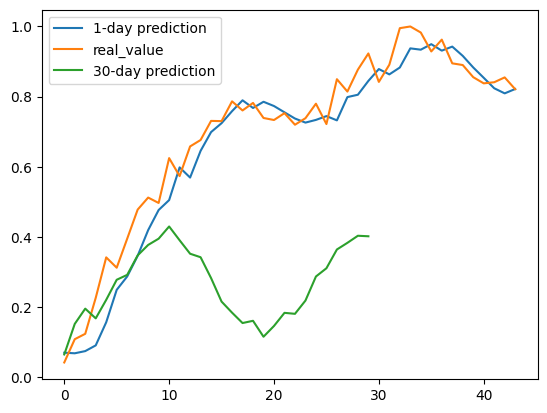

In [120]:
plt.plot(y_pred_list[0].numpy(), label="1-day prediction")
plt.plot(test_transformed[["close"]].to_numpy(), label="real_value")
plt.plot(long_term_pred, label="30-day prediction")
plt.legend()